In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
from scipy import stats
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3)
plt.rcParams['mathtext.default'] = 'regular'
savefig = False
# Constants
M_air = 28.97 # dry air [kg]
coeff_o3 = (M_air/48.00)*1e9 # convert mass mixing ratio to volume mixing ratio
str_o3 = '$O_3$'
str_djf = 'DJF'; str_mam = 'MAM'; str_jja = 'JJA'; str_son = 'SON'

In [2]:
# Read data
base = 'xnvtc'; sens = 'xnvth'; base_plt = 'CheT orig'; sens_plt = 'CheT revised'
path_to_ukca = Path('../data')
o3_base = iris.load_cube(str(path_to_ukca / base / f'{base}_o3.nc'))*coeff_o3
o3_sens = iris.load_cube(str(path_to_ukca / sens / f'{sens}_o3.nc'))*coeff_o3
# Path to figures
path_to_figs = Path('../../../results') / 'deltasign'
path_to_figs.mkdir(exist_ok=True)

In [3]:
# Calculate seasonal values
iris.coord_categorisation.add_season(o3_base, 'time', name='season')
iris.coord_categorisation.add_season(o3_sens, 'time', name='season')
o3_base_seasonal_mean = o3_base.aggregated_by('season', iris.analysis.MEAN)
o3_sens_seasonal_mean = o3_sens.aggregated_by('season', iris.analysis.MEAN)
o3_base_seasonal_var = o3_base.aggregated_by('season', iris.analysis.VARIANCE)
o3_sens_seasonal_var = o3_sens.aggregated_by('season', iris.analysis.VARIANCE)

### Stats

H0: two runs have identical mean species concentration.
Fail to reject H0: means are equal.
Reject H0: means are not equal.

if p > 0.05: means are equal (fail to reject H0)
else: means are not equal (reject H0)

Calculate the T-test for the means of two independent samples of scores. Use scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate'). This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

Note: Variances between UKCA runs are different...

#### Zonal seasonal means

In [4]:
# Calculate zonal means for each month
o3_base_znl_mean = o3_base.collapsed('longitude', iris.analysis.MEAN)
o3_sens_znl_mean = o3_sens.collapsed('longitude', iris.analysis.MEAN)
# Extract time series of zonal means by season
o3_base_znl_djf = o3_base_znl_mean.extract(iris.Constraint(season='djf'))
o3_sens_znl_djf = o3_sens_znl_mean.extract(iris.Constraint(season='djf'))
o3_base_znl_mam = o3_base_znl_mean.extract(iris.Constraint(season='mam'))
o3_sens_znl_mam = o3_sens_znl_mean.extract(iris.Constraint(season='mam'))
o3_base_znl_jja = o3_base_znl_mean.extract(iris.Constraint(season='jja'))
o3_sens_znl_jja = o3_sens_znl_mean.extract(iris.Constraint(season='jja'))
o3_base_znl_son = o3_base_znl_mean.extract(iris.Constraint(season='son'))
o3_sens_znl_son = o3_sens_znl_mean.extract(iris.Constraint(season='son'))
# Calculate p-values for zonal seasonal means by season
nlevs = o3_base.coord('level_height').shape[0]
nlats = o3_base.coord('latitude').shape[0]
_, o3_znl_djf_p = np.empty([nlevs,nlats]), np.empty([nlevs,nlats])
_, o3_znl_mam_p = np.empty([nlevs,nlats]), np.empty([nlevs,nlats])
_, o3_znl_jja_p = np.empty([nlevs,nlats]), np.empty([nlevs,nlats])
_, o3_znl_son_p = np.empty([nlevs,nlats]), np.empty([nlevs,nlats])
for i, lev in enumerate(o3_base.coord('level_height').points):
    for j, lat in enumerate(o3_base.coord('latitude').points):
        # use Welch's t-test
        _[i,j], o3_znl_djf_p[i,j] = stats.ttest_ind(o3_base_znl_djf.data[:,i,j], o3_sens_znl_djf.data[:,i,j], equal_var=False)
        _[i,j], o3_znl_mam_p[i,j] = stats.ttest_ind(o3_base_znl_mam.data[:,i,j], o3_sens_znl_mam.data[:,i,j], equal_var=False)
        _[i,j], o3_znl_jja_p[i,j] = stats.ttest_ind(o3_base_znl_jja.data[:,i,j], o3_sens_znl_jja.data[:,i,j], equal_var=False)
        _[i,j], o3_znl_son_p[i,j] = stats.ttest_ind(o3_base_znl_son.data[:,i,j], o3_sens_znl_son.data[:,i,j], equal_var=False)
# Calculate zonal seasonal means
o3_base_znl_seasonal_mean = o3_base_znl_mean.aggregated_by('season', iris.analysis.MEAN)
o3_sens_znl_seasonal_mean = o3_sens_znl_mean.aggregated_by('season', iris.analysis.MEAN)
# Calculate differences in zonal seasonal means
o3_znl_djf_diff = o3_sens_znl_seasonal_mean[0,...] - o3_base_znl_seasonal_mean[0,...]
o3_znl_mam_diff = o3_sens_znl_seasonal_mean[1,...] - o3_base_znl_seasonal_mean[1,...]
o3_znl_jja_diff = o3_sens_znl_seasonal_mean[2,...] - o3_base_znl_seasonal_mean[2,...]
o3_znl_son_diff = o3_sens_znl_seasonal_mean[3,...] - o3_base_znl_seasonal_mean[3,...]

In [5]:
# Zonal means plotting parameters
def stipple_zonal(cube, pval_arr, thresh=0.05):
    '''Stipple areas where p-values are lower than 0.05 (statistically significant). 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('latitude').points 
    yOrg = cube.coord('level_height').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape ) 
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints]
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)
znl_mean_pc_kwargs = dict(norm=MidpointNormalize(midpoint=0.), cmap='RdBu_r')
znl_mean_cr_kwargs = dict(levels=[0,5,10], cmap='Greys')
znl_pval_kwargs = dict(s=5, c='k', marker='.', alpha=1)
znl_seasonal_mean_orig_levs = np.arange(0,13000,1000)

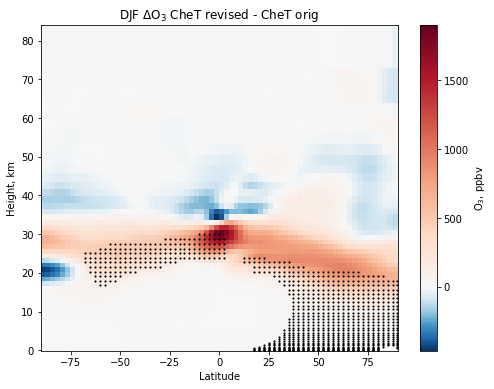

In [6]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
p0 = ax.pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_djf_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_djf_diff.data, **znl_mean_cr_kwargs)
ax.scatter(stipple_zonal(o3_znl_djf_diff, o3_znl_djf_p)[0], stipple_zonal(o3_znl_djf_diff, o3_znl_djf_p)[1], **znl_pval_kwargs)
ax.set_title(f'{str_djf} $\Delta${str_o3} {sens_plt} - {base_plt}')
fig.colorbar(p0, ax=ax, label=f'{str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax.set_xlabel('Latitude')
ax.set_ylabel('Height, km')
# ax.set_ylim(0,40000)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0, y=0);

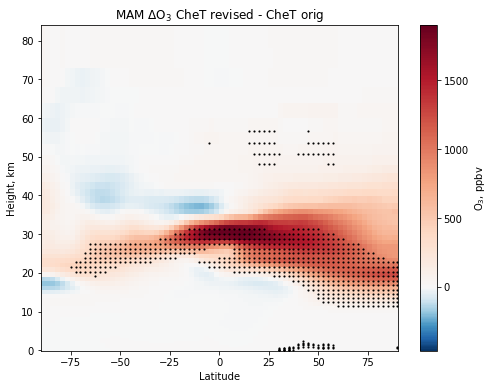

In [7]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
p0 = ax.pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_mam_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_mam_diff.data, **znl_mean_cr_kwargs)
ax.scatter(stipple_zonal(o3_znl_mam_diff, o3_znl_mam_p)[0], stipple_zonal(o3_znl_mam_diff, o3_znl_mam_p)[1], **znl_pval_kwargs)
ax.set_title(f'{str_mam} $\Delta${str_o3} {sens_plt} - {base_plt}')
fig.colorbar(p0, ax=ax, label=f'{str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax.set_xlabel('Latitude')
ax.set_ylabel('Height, km')
# ax.set_ylim(0,40000)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0, y=0);

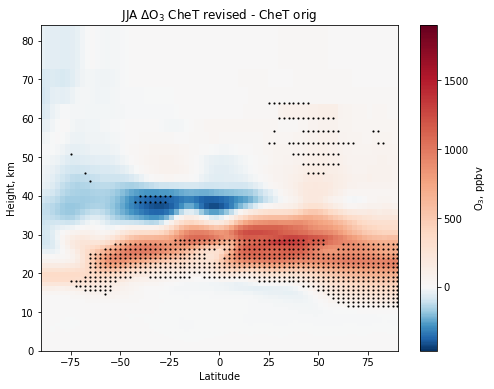

In [8]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
p0 = ax.pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_jja_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_jja_diff.data, **znl_mean_cr_kwargs)
ax.scatter(stipple_zonal(o3_znl_jja_diff, o3_znl_jja_p)[0], stipple_zonal(o3_znl_jja_diff, o3_znl_jja_p)[1], **znl_pval_kwargs)
ax.set_title(f'{str_jja} $\Delta${str_o3} {sens_plt} - {base_plt}')
fig.colorbar(p0, ax=ax, label=f'{str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax.set_xlabel('Latitude')
ax.set_ylabel('Height, km')
# ax.set_ylim(0,40000)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0, y=0);

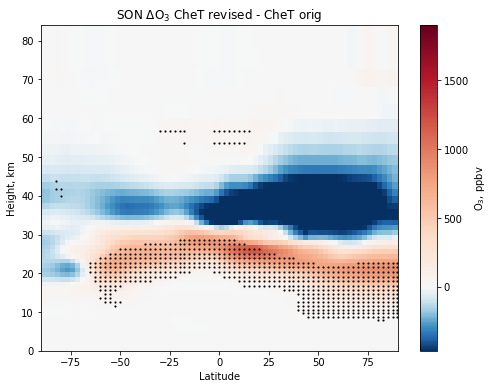

In [9]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
p0 = ax.pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_son_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_son_diff.data, **znl_mean_cr_kwargs)
ax.scatter(stipple_zonal(o3_znl_son_diff, o3_znl_son_p)[0], stipple_zonal(o3_znl_son_diff, o3_znl_son_p)[1], **znl_pval_kwargs)
ax.set_title(f'{str_son} $\Delta${str_o3} {sens_plt} - {base_plt}')
fig.colorbar(p0, ax=ax, label=f'{str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax.set_xlabel('Latitude')
ax.set_ylabel('Height, km')
# ax.set_ylim(0,40000)
ax.yaxis.set_major_formatter(FuncFormatter(m2km))
ax.margins(x=0, y=0);

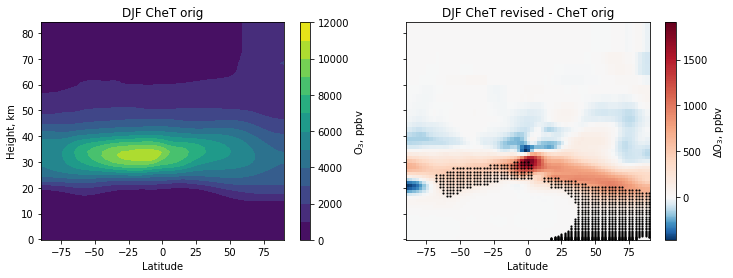

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_base_znl_seasonal_mean.data[0,...], 
                     levels=znl_seasonal_mean_orig_levs)
ax[0].set_title(f'{str_djf} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_o3}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_djf_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_djf_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(stipple_zonal(o3_znl_djf_diff, o3_znl_djf_p)[0], stipple_zonal(o3_znl_djf_diff, o3_znl_djf_p)[1], **znl_pval_kwargs)
ax[1].set_title(f'{str_djf} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_djf}.png', bbox_inches='tight')

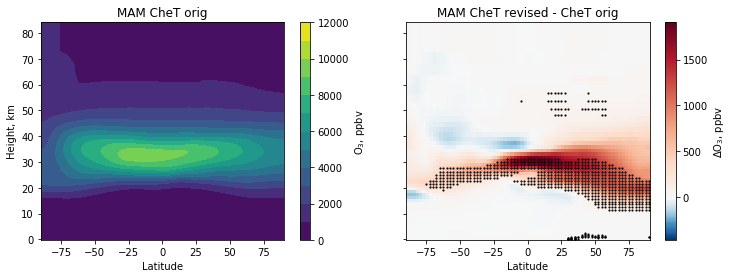

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_base_znl_seasonal_mean.data[1,...], 
                    levels=znl_seasonal_mean_orig_levs)
ax[0].set_title(f'{str_mam} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_o3}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_mam_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_mam_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(stipple_zonal(o3_znl_mam_diff, o3_znl_mam_p)[0], stipple_zonal(o3_znl_mam_diff, o3_znl_mam_p)[1], **znl_pval_kwargs)
ax[1].set_title(f'{str_mam} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_mam}.png', bbox_inches='tight')

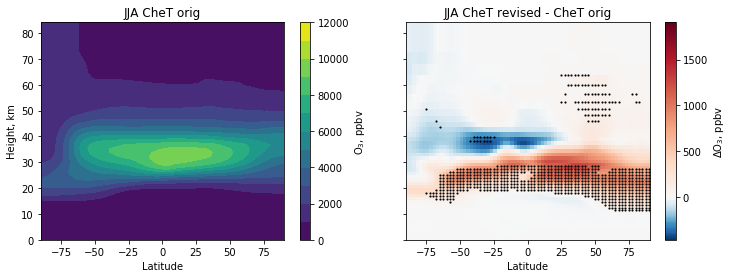

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_base_znl_seasonal_mean.data[2,...], 
                    levels=znl_seasonal_mean_orig_levs)
ax[0].set_title(f'{str_jja} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_o3}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_jja_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_jja_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(stipple_zonal(o3_znl_jja_diff, o3_znl_jja_p)[0], stipple_zonal(o3_znl_jja_diff, o3_znl_jja_p)[1], **znl_pval_kwargs)
ax[1].set_title(f'{str_jja} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_jja}.png', bbox_inches='tight')

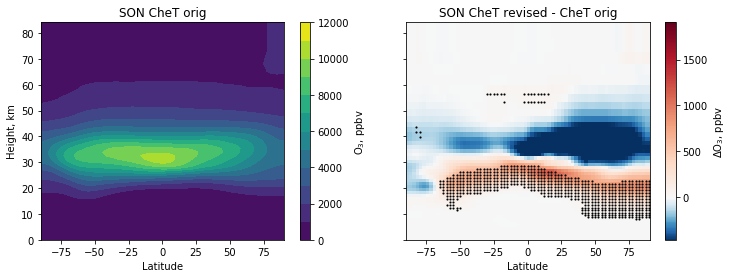

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_base_znl_seasonal_mean.data[3,...], 
                    levels=znl_seasonal_mean_orig_levs)
ax[0].set_title(f'{str_son} {base_plt}')
fig.colorbar(p00, ax=ax[0], label=f'{str_o3}, ppbv')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Height, km')
ax[0].yaxis.set_major_formatter(FuncFormatter(m2km))

p01 = ax[1].pcolormesh(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_son_diff.data, **znl_mean_pc_kwargs)
# p1 = ax.contour(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_znl_son_diff.data, **znl_mean_cr_kwargs)
ax[1].scatter(stipple_zonal(o3_znl_son_diff, o3_znl_son_p)[0], stipple_zonal(o3_znl_son_diff, o3_znl_son_p)[1], **znl_pval_kwargs)
ax[1].set_title(f'{str_son} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_o3}, ppbv')
# ax.clabel(p1, inline=1, fmt='%1.0f')
ax[1].set_xlabel('Latitude')
ax[1].margins(x=0, y=0);

if savefig: fig.savefig(path_to_figs / f'znl_seas_mean_{str_son}.png', bbox_inches='tight')

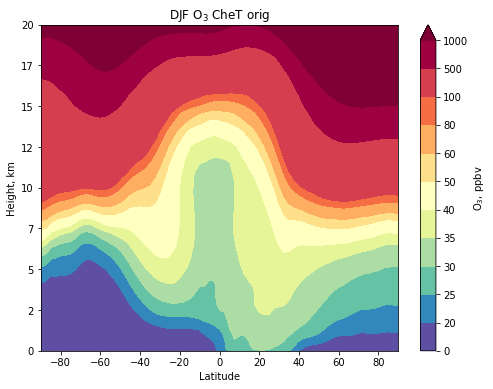

In [14]:
# Reproducing (almost) OConnor2014
znl_seasonal_mean_levs = [0,20,25,30,35,40,50,60,80,100,500,1000] # almost like in OConnor2014
znl_seasonal_mean_clrs = ['#5e4fa2','#3288bd','#66c2a5','#abdda4','#e6f598','#ffffbf','#fee08b','#fdae61','#f46d43','#d53e4f','#9e0142']
znl_seasonal_mean_cmap = mpl.colors.ListedColormap(znl_seasonal_mean_clrs)
znl_seasonal_mean_cmap.set_over('#7e0034')
znl_seasonal_mean_norm = mpl.colors.BoundaryNorm(znl_seasonal_mean_levs, znl_seasonal_mean_cmap.N)
znl_seasonal_mean_kwargs = dict(levels=znl_seasonal_mean_levs, cmap=znl_seasonal_mean_cmap, norm=znl_seasonal_mean_norm, extend='max')

fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
p0 = ax.contourf(o3_base.coord('latitude').points, o3_base.coord('level_height').points, o3_base_znl_seasonal_mean.data[0,...],
                 **znl_seasonal_mean_kwargs)
ax.set_title(f'{str_djf} {str_o3} {base_plt}')
fig.colorbar(p0, ax=ax, label=f'{str_o3}, ppbv', boundaries=znl_seasonal_mean_levs, ticks=znl_seasonal_mean_levs, spacing='uniform')
ax.set_xlabel('Latitude')
ax.set_ylabel('Height, km')
ax.set_ylim(0,20000)
ax.yaxis.set_major_formatter(FuncFormatter(m2km));

#### Surface seasonal means

In [15]:
# Extract time series of surface seasonal means
o3_base_srf_djf = o3_base.extract(iris.Constraint(season='djf'))[:,0,...]
o3_sens_srf_djf = o3_sens.extract(iris.Constraint(season='djf'))[:,0,...]
o3_base_srf_mam = o3_base.extract(iris.Constraint(season='mam'))[:,0,...]
o3_sens_srf_mam = o3_sens.extract(iris.Constraint(season='mam'))[:,0,...]
o3_base_srf_jja = o3_base.extract(iris.Constraint(season='jja'))[:,0,...]
o3_sens_srf_jja = o3_sens.extract(iris.Constraint(season='jja'))[:,0,...]
o3_base_srf_son = o3_base.extract(iris.Constraint(season='son'))[:,0,...]
o3_sens_srf_son = o3_sens.extract(iris.Constraint(season='son'))[:,0,...]
# Calculate p-values for surface seasonal means
nlats = o3_base.coord('latitude').shape[0]
nlons = o3_base.coord('longitude').shape[0]
_, o3_srf_djf_p = np.empty([nlats,nlons]), np.empty([nlats,nlons])
_, o3_srf_mam_p = np.empty([nlats,nlons]), np.empty([nlats,nlons])
_, o3_srf_jja_p = np.empty([nlats,nlons]), np.empty([nlats,nlons])
_, o3_srf_son_p = np.empty([nlats,nlons]), np.empty([nlats,nlons])
for i, lat in enumerate(o3_base.coord('latitude').points):
    for j, lon in enumerate(o3_base.coord('longitude').points):
        # use Welch's t-test
        _[i,j], o3_srf_djf_p[i, j] = stats.ttest_ind(o3_base_srf_djf.data[:,i,j], o3_sens_srf_djf.data[:,i,j], equal_var=False) 
        _[i,j], o3_srf_mam_p[i, j] = stats.ttest_ind(o3_base_srf_mam.data[:,i,j], o3_sens_srf_mam.data[:,i,j], equal_var=False)
        _[i,j], o3_srf_jja_p[i, j] = stats.ttest_ind(o3_base_srf_jja.data[:,i,j], o3_sens_srf_jja.data[:,i,j], equal_var=False)
        _[i,j], o3_srf_son_p[i, j] = stats.ttest_ind(o3_base_srf_son.data[:,i,j], o3_sens_srf_son.data[:,i,j], equal_var=False)
# Calculate differences in surface seasonal means
o3_srf_djf_diff = o3_sens_seasonal_mean[0,0,...] - o3_base_seasonal_mean[0,0,...]
o3_srf_mam_diff = o3_sens_seasonal_mean[1,0,...] - o3_base_seasonal_mean[1,0,...]
o3_srf_jja_diff = o3_sens_seasonal_mean[2,0,...] - o3_base_seasonal_mean[2,0,...]
o3_srf_son_diff = o3_sens_seasonal_mean[3,0,...] - o3_base_seasonal_mean[3,0,...]
# Add cyclic point for plotting on a global map
cyc_o3_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(o3_srf_djf_diff.data, coord=o3_srf_djf_diff.coord('longitude').points)
cyc_o3_mam_diff = cartopy.util.add_cyclic_point(o3_srf_mam_diff.data)
cyc_o3_jja_diff = cartopy.util.add_cyclic_point(o3_srf_jja_diff.data)
cyc_o3_son_diff = cartopy.util.add_cyclic_point(o3_srf_son_diff.data)
cyc_o3_base_seasonal_mean = cartopy.util.add_cyclic_point(o3_base_seasonal_mean.data)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


In [16]:
# Surface mean difference plotting parameters
def stipple_srf(cube, pval_arr, thresh=0.05, central_long=0):
    '''Stipple areas where p-values are lower than 0.05 (statistically significant). 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape ) 
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)
srf_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(-16,18,2), cmap='RdBu_r')
srf_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=1)
srf_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(0,80,10))

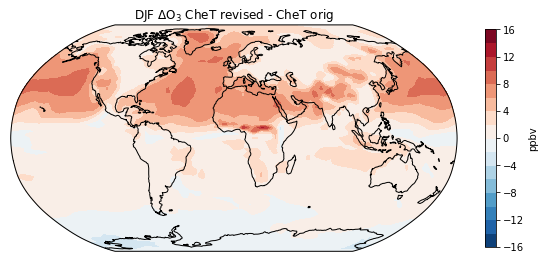

In [28]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p0 = ax.contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_djf_diff.data, **srf_diff_cf_kwargs)
# ax.scatter(stipple_srf(o3_srf_djf_diff, o3_srf_djf_p)[0], stipple_srf(o3_srf_djf_diff, o3_srf_djf_p)[1], **srf_pval_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_djf} $\Delta${str_o3} {sens_plt} - {base_plt}')
fig.colorbar(p0, shrink=0.4, label='ppbv')
if savefig: fig.savefig(path_to_figs / f'{str_djf}_no_stats.png', bbox_inches='tight')

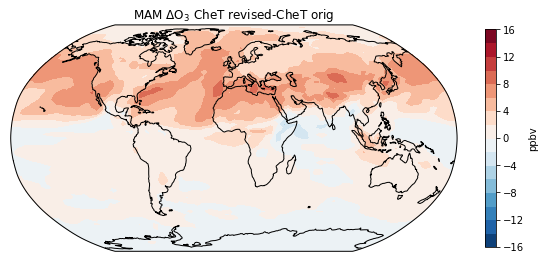

In [29]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p0 = ax.contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_mam_diff.data, **srf_diff_cf_kwargs)
# ax.scatter(stipple_srf(o3_srf_mam_diff, o3_srf_mam_p)[0], stipple_srf(o3_srf_mam_diff, o3_srf_mam_p)[1], **srf_pval_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_mam} $\Delta${str_o3} {sens_plt}-{base_plt}')
fig.colorbar(p0, shrink=0.4, label='ppbv')
if savefig: fig.savefig(path_to_figs / f'{str_mam}_no_stats.png', bbox_inches='tight')

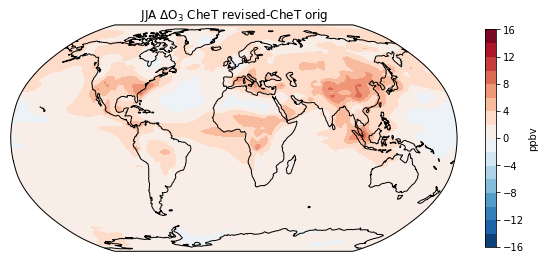

In [30]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p0 = ax.contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_jja_diff.data, **srf_diff_cf_kwargs)
# ax.scatter(stipple_srf(o3_srf_jja_diff, o3_srf_jja_p)[0], stipple_srf(o3_srf_jja_diff, o3_srf_jja_p)[1], **srf_pval_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_jja} $\Delta${str_o3} {sens_plt}-{base_plt}')
fig.colorbar(p0, shrink=0.4, label='ppbv')
if savefig: fig.savefig(path_to_figs / f'{str_jja}_no_stats.png', bbox_inches='tight')

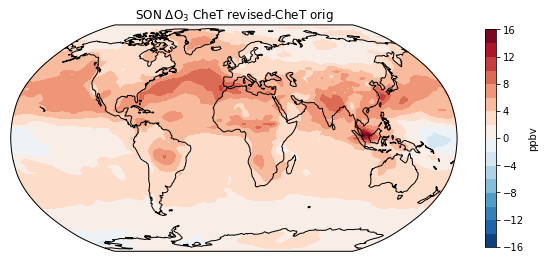

In [31]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p0 = ax.contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_son_diff.data, **srf_diff_cf_kwargs)
# ax.scatter(stipple_srf(o3_srf_son_diff, o3_srf_son_p)[0], stipple_srf(o3_srf_son_diff, o3_srf_son_p)[1], **srf_pval_sc_kwargs)
ax.coastlines()
ax.set_global()
ax.set_title(f'{str_son} $\Delta${str_o3} {sens_plt}-{base_plt}')
fig.colorbar(p0, shrink=0.4, label='ppbv')
if savefig: fig.savefig(path_to_figs / f'{str_son}_no_stats.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_base_seasonal_mean[0,0,...].data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_djf} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_o3}, ppbv')

p01 = ax[1].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_djf_diff.data, **srf_diff_cf_kwargs)
ax[1].scatter(stipple_srf(o3_srf_djf_diff, o3_srf_djf_p)[0], stipple_srf(o3_srf_djf_diff, o3_srf_djf_p)[1], **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_djf} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_o3}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_djf}.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_base_seasonal_mean[1,0,...].data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_mam} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_o3}, ppbv')

p01 = ax[1].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_mam_diff.data, **srf_diff_cf_kwargs)
ax[1].scatter(stipple_srf(o3_srf_mam_diff, o3_srf_mam_p)[0], stipple_srf(o3_srf_mam_diff, o3_srf_mam_p)[1], **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_mam} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_o3}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_mam}.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_base_seasonal_mean[2,0,...].data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_jja} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_o3}, ppbv')

p01 = ax[1].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_jja_diff.data, **srf_diff_cf_kwargs)
ax[1].scatter(stipple_srf(o3_srf_jja_diff, o3_srf_jja_p)[0], stipple_srf(o3_srf_jja_diff, o3_srf_jja_p)[1], **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_jja} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_o3}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_jja}.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_base_seasonal_mean[3,0,...].data, **srf_mean_cf_kwargs)
ax[0].coastlines()
ax[0].set_global()
ax[0].set_title(f'{str_son} {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.4, label=f'{str_o3}, ppbv')

p01 = ax[1].contourf(cyclic_lons, o3_base.coord('latitude').points, cyc_o3_son_diff.data, **srf_diff_cf_kwargs)
ax[1].scatter(stipple_srf(o3_srf_son_diff, o3_srf_son_p)[0], stipple_srf(o3_srf_son_diff, o3_srf_son_p)[1], **srf_pval_sc_kwargs)
ax[1].coastlines()
ax[1].set_global()
ax[1].set_title(f'{str_son} {sens_plt} - {base_plt}')
fig.colorbar(p01, ax=ax[1], shrink=0.4, label=f'$\Delta${str_o3}, ppbv')

fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'srf_seas_mean_{str_son}.png', bbox_inches='tight')